In [4]:
#################################################################################################
# THIS IS THE ONE THAT WORKS DO NOT DELETE
# sets up a keysight frequency counter to trigger on external voltage change
# collects data from the onboard buffer every few seconds saving to CSV file
#################################################################################################

import nidaqmx
import time
import pyvisa as visa
import pandas as pd
import Utilities as util
from os import path
import daqUtils
from pymeasure.instruments.keithley import Keithley2000
from pymeasure.adapters import PrologixAdapter
import math

########################################## Helper functions go here ##############################################################################
def getTrigCountCmd(num):
    trig_num_cmd = 'TRIG:COUN ' + str(num)
    return trig_num_cmd

def getTrigSourceCmd(sr):
    trig_src_cmd = 'TRIG:SOUR '+ sr
    return trig_src_cmd

def collectionTimeToNumCycles(col_time, trig_count, lowtime, hightime):
    time_per_point = lowtime + hightime
    time_per_cycle = time_per_point * trig_count
    num_cycles = col_time/time_per_cycle
    #round up, to the nearest int
    num_cycles = math.ceil(num_cycles)
    return int(num_cycles)
####################################################################################################################################################


######################################### Set the your collection variables here ###################################################################
#
# trig_count = the number of measurements collected before that data is offloaded to a csv file
# trig_count_cmd = a SCPI command created from the specified trigger count
# trig_source = the trigger source for the instruments. It can be IMM, EXT, BUS, etc. For this it should be EXT
# trig_source_cmd = a SCPI command created from the specified trigger source
# high_V = the high voltage value to send as a trigger from the DAQ
# low_V = the low voltage value to send as a trigger from the DAQ, this should be 0.0
# high_time = the amount of time in seconds to send the high voltage 
# low_time = the amount of time in seconds to send the low voltage 
# how_long_collec = the length of time you want to collect data for in seconds, this will be used to determine how many cycles to collect for.
# how_many_cycles = this is determined from the length of time it takes to collect one data point, and how long the user wishes to collec data for.
# folder = where do you want data files to be saved? remember to escape back slashes on windows
#
#####################################################################################################################################################
trig_count = 10
trig_count_cmd = getTrigCountCmd(trig_count)
trig_source = 'EXT'
trig_source_cmd = getTrigSourceCmd(trig_source)
high_V = 2.5
low_V = 0.0
high_time = 0.5
low_time = 0.5
how_long_collect =600
how_many_cycles = collectionTimeToNumCycles(how_long_collect, trig_count, low_time, high_time)
folder = 'Data\\kseExperiment\\'

keysight_addr = 'USB0::0x0957::0x1807::MY58430132::INSTR' #name/address for the keysight connected to the computer
daq_path = 'Dev2/ao0' #the path to the daq
dmm_addr = 'ASRL6::INSTR' #address of USB connected to computer
gpib_channel_no = 1 #the channel number for the GPIB connection from the dmm. this can be set on the dmm to anything between 1 and 16


####################################################################################################################################################
# Data Collection starts here!
####################################################################################################################################################

print('Collecting data for '+str(how_many_cycles)+' cycles.')

#do all the document prep at the beginning so it doesn't slow down collection later
#create a new csv file at the specified location
filename = util.dtStringForFilename()
fp = folder + filename
file = open(fp, 'a')
#create an empty data frame and save the headers to the file
df_headers = pd.DataFrame({'Frequencies': [], 'Voltages': [], 'Times':[], 'Timestamps':[]})
df_headers.to_csv(fp, mode='a', index=False)
print('Output file created')

# open the resource manager so we can connect to the keysight and the keithley
rm = visa.ResourceManager()



# Keysight connection setup
freq_counter = rm.open_resource(keysight_addr)
freq_counter.encoding = 'latin_1'
freq_counter.source_channel = 'CH1'

# Keysight data collection set up
## reset everything and clear the event queues
freq_counter.write('*RST')
freq_counter.write('STAT:PRES')
freq_counter.write('*CLS')
## set the type of measurement to frequency
freq_counter.write('CONF:FREQ')
freq_counter.write(trig_source_cmd)
freq_counter.write('TRIG:SLOP POS')
freq_counter.write(trig_count_cmd)

# DAQ Setup and task initialization
task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan(daq_path)
print('Starting Collection')
task.start()
task.write(0.0)#make sure we are starting at 0V

# Initialize the keysight
freq_counter.write('INIT')

#do one trigger cycle to get rid of the empty data point that apparently gets collected for reasons?
#I hate that this is a thing, but it appears to be a thing, so we're going to roll with it
task.write(2.0)
time.sleep(0.1)
task.write(0.0)
time.sleep(0.1)
freq_counter.query('R?')#remove the empty data point from the data register, so our time stamps will match up with the frequencies collected

# Continuing the things I hate, I have to wait until after the garbage cycle completes on the keysight to set up the dmm
# because if I don't it gets into a mystery state where it doesn't understand how to send data properly and I don't know why
# I would like to fix this correctly by figuring out how to reliably reset the dmm to the state it is in at power up, but since I 
# have yet to figure that out, we're doing this stupid work around
#Keithley dmm connection set up

adapter = PrologixAdapter(dmm_addr, gpib_channel_no) #create prologix adapter and connect to GPIB w/ address 1
dmm = Keithley2000(adapter) #create the instrument using the adapter

# Keithley data collection set up
## reset everything and clear the event queues
dmm.reset()
## need to set trigger type to external
dmm.write(trig_source_cmd)
## set trigger count to the desired number of datapoints per collection cycle
dmm.write(trig_count_cmd)
## set sample count to 1 (this is one sample per trigger)
dmm.write('SAMP:COUN 1')

# set up the data trace so I can get more than one mesurement when we reach the end of the collection cycle
# I have to do this here so all the data points stay in sync because of the weird empty value the keysight likes to for it's first trigger cycle
cmd_trace = 'TRAC:POIN ' + str(trig_count)
dmm.write(cmd_trace)
dmm.write('TRAC:FEED SENS1;FEED:CONT NEXT')
dmm.write('INIT')

cycle_num=1

while (cycle_num<=how_many_cycles):
    print('Starting Data Collection Cycle '+str(cycle_num))
    times = [] #the timestamps will go here
    frequencies = ''
    dmm_vals = ''
    
    times = daqUtils.genAnalogTriggerCycle(task, trig_count, high_V, low_V, high_time, low_time)

    #task.write(0.0)# always end at 0.0V
    task.stop()
    print('Ending Collection Cycle '+str(cycle_num))

    try:
        frequencies = freq_counter.query('FETC?')
    except: 
        print('I regret to inform you that something done f*cked up with the Keysight and there is no data.')
        print('Ending data collection.')
        task.close()
        freq_counter.close()
        adapter.close()
        rm.close()

    try: 
        dmm_vals = dmm.ask('TRAC:DATA?')
    except:  
        print('I regret to inform you that something done f*cked up with the Keysight and there is no data.')
        print('Ending data collection.')
        task.close()
        freq_counter.close()
        adapter.close()
        rm.close()   

    #now I need to make the data into some sort of format that we can easily put in a text file
    frequencies = util.stringToPandasSeries(frequencies, ',')
    dmm_vals = util.stringToPandasSeries(dmm_vals, ',')
    hrdates, hrtimes = util.formatTimestampsForCSV(times)
    
    df = pd.DataFrame({
        'Frequency': frequencies,
        'Voltage': dmm_vals,
        'Time': hrtimes, 
        'Timestamps': times
    })
    df.to_csv(fp, mode='a', index=False, header=False)
    cycle_num = cycle_num+1
    
#close the DAQ taks
task.close()
#close the csv file
file.close()
#close the connections
openres = rm.list_opened_resources()
print('Closing Connection with ', openres)
freq_counter.close()
adapter.close()
rm.close()




Output file created
Starting Collection
Starting Data Collection Cycle 1
Ending Collection Cycle 1
I regret to inform you that something done f*cked up with the Keysight and there is no data.
Ending data collection.
I regret to inform you that something done f*cked up with the Keysight and there is no data.
Ending data collection.


c:\Users\SAAM GROUP\anaconda3\Lib\site-packages\nidaqmx\task.py:355: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<3>" but task was already closed.
  warnings.warn(


ValueError: array length 10 does not match index length 1

In [1]:
#################################################################################################
# Voltage testing module
# this module connects to the DAQ and creates an analog output task
# that task then sends 2V through the analog output for a few seconds before returning to 0V
# the purpose is to allow for testing of external triggers without having to hook up the actual instruments themselves
#################################################################################################

import nidaqmx
import time


task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan("Dev2/ao0")
task.start()
task.write(0.0)#make sure we are starting at 0V
time.sleep(1)

#do one trigger cycle to get rid of the empty data point that apparently gets collected for reasons?
#I hate that this is a thing, but it appears to be a thing, so we're going to roll with it
print("sending 2V now")
task.write(2.0)
time.sleep(5)
task.write(0.0)
time.sleep(1)
task.stop()


#close the DAQ taks
task.close()


sending 2V now


In [1]:
#################################################################################################
# Available connections module
# 
# This module lists the available daw connections via the nidaqmx libray and the available 
# instruments via the pyvisa library. Use this to check the names and paths to your instruments
# when setting up data collection. 
#################################################################################################

import nidaqmx.system as sys
import pyvisa as visa

system = sys.System.local()

print('Available daq physical analog output channels: ')
for device in system.devices: 
    print(device.ao_physical_chans.channel_names)

print()

rm = visa.ResourceManager()
print('Available instrument resources: ')
print(rm.list_resources())
rm.close()


Available daq physical analog output channels: 
['Dev1/ao0', 'Dev1/ao1']
['Dev2/ao0', 'Dev2/ao1']

Available instrument resources: 
('USB0::0x0957::0x1807::MY58430132::INSTR', 'ASRL6::INSTR')


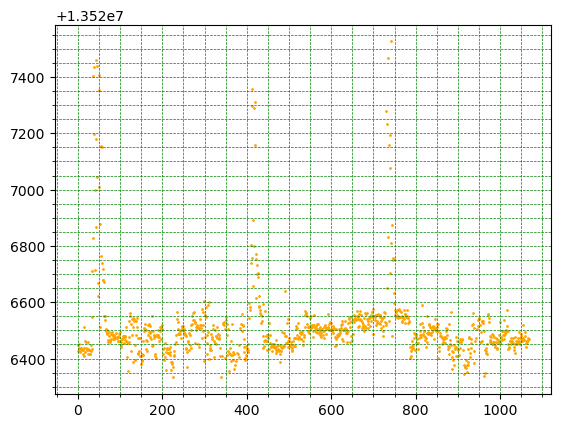

In [18]:
import pandas as pd
import KSEExperimentUtils as kse
import numpy as np

import matplotlib.pyplot as plt

###### plot settings ######

dot_size = 1
grid_color = 'green'

def setupPlot():
    plt.grid(which = 'major', color = grid_color, linestyle = '--', linewidth = 0.5)
    plt.grid(which = 'minor', color = grid_color, linestyle = '--', linewidth = 0.5)
    plt.minorticks_on()

###########################

filepath = "Data/2024-06-21-11_05_17.511167"
filepath2 = "Data/2024-06-26-11_45_55.085837"
filepath3 = filepath2+"_processed.csv"

#d = kse.processAllData(filepath2+".csv", 'rb85', 'high')
#kse.createCSVProcessedData(filepath3, d)

df = pd.read_csv(filepath3)

arr_size = len(df['Time'])

times = np.zeros(arr_size)
ks_freq = np.zeros(arr_size)
dmm_freq = np.zeros(arr_size)
ks_sub_dmm = np.zeros(arr_size)

for i in range(0,arr_size):
    times[i] = float(df['Time'][i])
    ks_freq[i] = float(df['Keysight'][i])
    dmm_freq[i] = float(df['DMM'][i])
    ks_sub_dmm[i] = float(df['Adjusted Keysight Data'][i])

#print(times)
#print(ks_freq)
#print(dmm_freq)

#gr = argrelextrema(ks_freq, np.greater)

#print(gr)

#d = d.set_index('Time')
setupPlot()
#plt.scatter(times, ks_freq, s=dot_size)
#plt.scatter(times, dmm_freq, s=dot_size, color = 'red')
plt.scatter(times, ks_sub_dmm, s=dot_size, color = 'orange')
plt.show()





In [7]:
import pyvisa as visa
import platform

rm = visa.ResourceManager()
resources = []
for r in rm.list_resources():
    resources.append(r)

print(resources)

my_system = platform.uname()
print(my_system)

['ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR']
uname_result(system='Darwin', node='Eleanors-MacBook-Air.local', release='23.5.0', version='Darwin Kernel Version 23.5.0: Wed May  1 20:16:51 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8103', machine='x86_64')
